In [1]:
# Install required modules
#!pip install geopandas numpy pandas matplotlib seaborn shapely pyproj netCDF4 scikit-learn
# Install all necessary modules before importing them
# Run within the Jupyter Notebook system or ensure these modules are installed
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
print(gpd.__version__)

1.0.1


In [2]:
# Import all functions from the required modules
from cordo_sherpa_module import *
from cordo_ineris_module import *
from correction_module import *
from expo_functions_module import *
from mortality_analysis_module import *
from plot_module import *

print("Successfully loaded all modules")

loaded defined RR values
Successfully loaded mean conc command
Successfully loaded plotting command
Successfully loaded all modules


In [3]:
# Paths to the files
path_fichier_shp = "data/2-output-data/donnees_shp"
title_shp = "donnees_insee_iris"
path_fichier_pourcents = "data/2-output-data"
title_pourcents = "pourcents"

# Load the concentration points
conc_points = coordo_sherpa(sc="s1", pol="ug_NO2", year=2019)

# Load the exported data
donnees_exportees = gpd.read_file(os.path.join(path_fichier_shp, f"{title_shp}.shp"))

# Transform the CRS of the exported data to match the concentration points
donnees_exportees_transformed = donnees_exportees.to_crs(conc_points.crs)

# Check if CRSs are the same
if conc_points.crs == donnees_exportees_transformed.crs:
    print("CRS for conc_points_transformed and donnees_exportees_transformed are the same.")
else:
    print("CRS for conc_points_transformed and donnees_exportees_transformed are different.")

grille_combinee = gpd.read_file(os.path.join(path_fichier_pourcents, f"{title_pourcents}.shp"))
grille_combinee = grille_combinee.to_crs(conc_points.crs)

Concentrations in 2019 and 2019 are calculated for the pollutant 'ug_no2' (s1).
CRS for conc_points_transformed and donnees_exportees_transformed are the same.


In [4]:
# Define paths for shapefiles
path_fichier_shp = "data/2-output-data/donnees_shp"
path_fichier_shp_1 = "data/2-output-data/donnees_shp_1"
path_fichier_shp_2 = "data/2-output-data/donnees_shp_2"
path_fichier_shp_3 = "data/2-output-data/donnees_shp_3"
path_fichier_pourcents = "data/2-output-data"

# Titles for INSEE Data
title_shp = "donnees_insee_iris"
title_shp_1 = "donnees_insee_iris_toutage_1"
title_shp_2 = "donnees_insee_iris_toutage_2"
title_shp_3 = "donnees_insee_iris_toutage_3"
title_pourcents = "pourcents"

# Read shapefiles into GeoDataFrames
donnees_shp_1 = gpd.read_file(os.path.join(path_fichier_shp_1, f"{title_shp_1}.shp"))
donnees_shp_2 = gpd.read_file(os.path.join(path_fichier_shp_2, f"{title_shp_2}.shp"))
donnees_shp_3 = gpd.read_file(os.path.join(path_fichier_shp_3, f"{title_shp_3}.shp"))
# Combine the three GeoDataFrames
donnees_merged = gpd.GeoDataFrame(pd.concat([donnees_shp_1, donnees_shp_2, donnees_shp_3], ignore_index=True))


In [5]:
import geopandas as gpd  # For geographic data operations
import matplotlib.pyplot as plt  # For plotting

#Plot unified map with all clusters shown
def plot_unified_iris_map_by_clusters(
    iris_level_results, iris_shapefile, columns_to_plot, titles=None, cmap="tab10", base_path="data/2-output-data"
):
    # Validation: Check if 'iriscod' column is present in both dataframes
    if "comcod" not in iris_level_results.columns:
        raise ValueError(
            "'comcod' column is missing in the 'iris_level_results' data. "
            f"Available columns in 'iris_level_results': {iris_level_results.columns.tolist()}"
        )
    if "comcod" not in iris_shapefile.columns:
        raise ValueError(
            "'comcod' column is missing in the 'iris_shapefile' data. "
            f"Available columns in 'iris_shapefile': {iris_shapefile.columns.tolist()}"
        )

    # Merge results with shapefile
    plot_data = iris_shapefile.merge(iris_level_results, on="comcod", how="left")

    # Check for and handle duplicate geometry columns after merging
    duplicate_geometry_cols = ['geometry_x', 'geometry_y']
    if all(col in plot_data.columns for col in duplicate_geometry_cols):
        print(f"Duplicate geometry columns detected: {duplicate_geometry_cols}. Prioritizing 'geometry_x'.")
        # Unify geometry columns
        plot_data['geometry'] = plot_data['geometry_x']
        # Drop duplicate columns
        plot_data.drop(columns=duplicate_geometry_cols, inplace=True)

    # Ensure the 'geometry' column is set as the active geometry
    if "geometry" in plot_data.columns:
        plot_data.set_geometry("geometry", inplace=True)

    # Ensure clustering into 'area_cluster'
    if "area_cluster" not in plot_data.columns:
        raise ValueError("'area_cluster' column is missing in the data. Please check input data.")

    if titles is None:
        titles = columns_to_plot

    # Create unified map with subplots
    n_maps = len(columns_to_plot)
    fig, axes = plt.subplots(1, n_maps, figsize=(18, 8))

    for i, column in enumerate(columns_to_plot):
        if pd.api.types.is_numeric_dtype(plot_data[column]):
            # Check for non-empty geometries
            if plot_data.geometry.is_empty.all():
                print(f"Warning: Data contains only empty geometries. Skipping plotting for {column}.")
                continue

            # Plot the data for the given column
            plot_data.plot(
                column="area_cluster",
                cmap=cmap,
                linewidth=0.2,
                edgecolor="black",
                legend=True,
                ax=axes[i],
                alpha=0.75,
            )

            # Overlay numeric data as transparency shading
            plot_data.plot(
                column=column,
                cmap="OrRd",
                linewidth=0.1,
                edgecolor="white",
                legend=True,
                ax=axes[i],
                alpha=0.5,
            )

            # Set title for the map
            axes[i].set_title(f"{titles[i]} Across Clusters", fontsize=14, fontweight="bold")
            axes[i].axis("off")
        else:
            axes[i].set_title(f"{titles[i]} (Non-numeric data)", fontsize=14, fontweight="bold")
            axes[i].axis("off")

    plt.tight_layout()

    # Save the unified map as PNG
    output_path = os.path.join(base_path, "iris_unified_mortality_map.png")
    plt.savefig(output_path, dpi=300)
    print(f"Unified map saved to {output_path}")

    # Ensure the plot is displayed
    plt.show()


In [6]:
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union

if isinstance(donnees_exportees, gpd.GeoDataFrame) and not donnees_exportees.empty and "comcod" in donnees_exportees.columns:
    try:
        print("Validating geometries...")
        donnees_exportees["geometry"] = donnees_exportees["geometry"].apply(lambda g: g.buffer(0) if not g.is_valid else g)

        if donnees_exportees.crs is None:
            raise ValueError("Missing CRS. Define a valid CRS before proceeding.")
        if not donnees_exportees.crs.is_projected:
            donnees_exportees = donnees_exportees.to_crs("EPSG:3035")
            print("Reprojected to EPSG:3035 for accurate area computation.")

        print("Aggregating to commune level...")
        commune = (
            donnees_exportees.groupby("comcod")
            .agg(
                pop2019=("pop2019", "sum"),
                geometry=("geometry", lambda x: unary_union([g.buffer(0) for g in x if g.is_valid]))
            )
            .reset_index()
        )
        commune = gpd.GeoDataFrame(commune, geometry="geometry", crs=donnees_exportees.crs)

        print("Calculating population density...")
        commune["area_km2"] = commune.geometry.area / 1e6
        commune["pop_density"] = commune["pop2019"] / commune["area_km2"].replace(0, np.nan)

        print("Classifying into Urban dense / Semi-urban / Rural...")
        def classify_cluster(row):
            pop = row["pop2019"]
            density = row["pop_density"]
            if pop >= 5000 and density >= 1500:
                return "Urban dense"
            elif pop >= 5000 and 300 <= density < 1500:
                return "Semi-urban"
            else:
                return "Rural"

        commune["area_cluster"] = commune.apply(classify_cluster, axis=1)

        print("Merging classification back into IRIS-level data...")
        donnees_exportees = donnees_exportees.merge(
            commune[["comcod", "area_cluster", "pop_density"]],
            on="comcod",
            how="left"
        )

        donnees_exportees["geometry"] = donnees_exportees["geometry"].apply(lambda g: g.buffer(0) if not g.is_valid else g)

        # ✅ Ensure the column exists before value_counts
        if "area_cluster" in donnees_exportees.columns:
            print("Classification completed. Cluster counts:")
            print(donnees_exportees["area_cluster"].value_counts())
        else:
            print("Warning: 'area_cluster' column not found after merge.")

    except Exception as e:
        print(f"Error during area cluster creation: {e}")
else:
    print("Input GeoDataFrame is invalid or missing required 'comcod' column.")


Validating geometries...
Aggregating to commune level...
Calculating population density...
Classifying into Urban dense / Semi-urban / Rural...
Merging classification back into IRIS-level data...
Classification completed. Cluster counts:
area_cluster
Rural          35952
Urban dense     7448
Semi-urban      5190
Name: count, dtype: int64


In [ ]:
import time  # For monitoring performance
import seaborn as sns  # For boxplot visualization
import geopandas as gpd

# Configuration
scenarios = ["s1"]  # Multiple scenarios now for testing
pollutants = ["ug_PM25_RH50"]  # ug_PM25_RH50
years = [2030]

# Preallocate data storage
all_data = []

# Iterate over all combinations
total_iterations = len(scenarios) * len(pollutants) * len(years)
current_iteration = 0

for scenario in scenarios:
    for pollutant in pollutants:
        # If coordo_ineris does not depend on year, move this outside year loop
        try:
            conc_ineris = coordo_ineris(pollutant)
        except Exception as e:
            print(f"Error loading conc_ineris for {pollutant}: {e}")
            continue

        for year in years:
            current_iteration += 1
            start_time = time.time()
            print(f"\nProcessing {current_iteration}/{total_iterations} - Scenario: {scenario}, Pollutant: {pollutant}, Year: {year}")

            try:
                # Step 1: Get modeled concentrations and correct them
                conc_points = coordo_sherpa(scenario, pollutant, year)
                conc_corrigee = correction(conc_points, conc_ineris)

                # Step 2: Calculate exposure
                donnees_expo = expo(donnees_exportees_transformed, conc_corrigee, grille_combinee)

                print(f"Exposure data sample for scenario {scenario}, pollutant {pollutant}:")
                print(donnees_expo.head())

                # Step 3: Compute mortality
                comcod_mortality_data = calculate_com_level_mortality_age_specific(
                    donnees_merged, donnees_expo, year, pollutant
                )
                print(comcod_mortality_data[["comcod", "total_mortality_avoided"]].head())

                # Step 4: Merge area_cluster info
                if "comcod" in donnees_exportees_transformed.columns and "comcod" in comcod_mortality_data.columns:
                    comcod_mortality_data = comcod_mortality_data.merge(
                        donnees_exportees_transformed[["comcod", "area_cluster"]],
                        on="comcod",
                        how="left"
                    )

                    print(f"Comcod mortality data after merging area clusters for {scenario}, {pollutant}:")
                    print(comcod_mortality_data.head())

                    # Step 5: Append data efficiently using itertuples
                    for row in comcod_mortality_data.itertuples(index=False):
                        all_data.append({
                            "Year": year,
                            "Scenario": scenario,
                            "Pollutant": "PM2.5" if pollutant == "ug_PM25_RH50" else "NO2",
                            "total_mortality_avoided": row.total_mortality_avoided,
                            "years_gained_age_specific": row.total_years_gained,
                            "Area_Cluster": getattr(row, 'area_cluster', None),
                            "comcod": row.comcod,
                            "geometry": row.geometry
                        })
                else:
                    print("Key column 'comcod' is missing in one of the datasets. Skipping aggregation step.")

            except Exception as e:
                print(f"Error processing Scenario: {scenario}, Pollutant: {pollutant}, Year: {year} - {e}")

            finally:
                elapsed_time = time.time() - start_time
                print(f"Completed {current_iteration}/{total_iterations} in {elapsed_time:.2f} seconds.")

# Final Step: Convert to GeoDataFrame and plot once
if all_data:
    gdf_all_data = gpd.GeoDataFrame(
        all_data,
        geometry=[row["geometry"] for row in all_data],
        crs=donnees_exportees_transformed.crs
    )
    gdf_all_data.set_geometry("geometry", inplace=True)

    plot_unified_iris_map_by_clusters(
        iris_level_results=gdf_all_data,
        iris_shapefile=donnees_exportees_transformed,
        columns_to_plot=["total_mortality_avoided", "years_gained_age_specific"],
        titles=["Mortality Avoided (Aggregated)", "Years Gained (Aggregated)"],
        cmap="tab10",
        base_path="data/2-output-data"
    )

Starting coordo_ineris function
Loading data from data/1-processed-data/SHERPA/conc-2019/Reanalysed_FRA_2019_PM25_avgannual_Ineris_v.Jan2024.nc
Finished processing coordo_ineris function

Processing 1/1 - Scenario: s1, Pollutant: ug_PM25_RH50, Year: 2030
Concentrations in 2019 and 2030 are calculated for the pollutant 'ug_pm25_rh50' (s1).
Bounds of conc_points: [-4.75       41.375       9.55000019 51.07500076]
Bounds of conc_ineris: [-5.14062 41.33602  9.54688 51.08602]


Debugging Data Distribution:
                      count      mean       std  min       25%       50%  \
Scenario Pollutant                                                         
s1       NO2        48590.0  0.150442  0.205943  0.0  0.012411  0.048582   

                         75%       max  
Scenario Pollutant                      
s1       NO2        0.230095  2.694918  


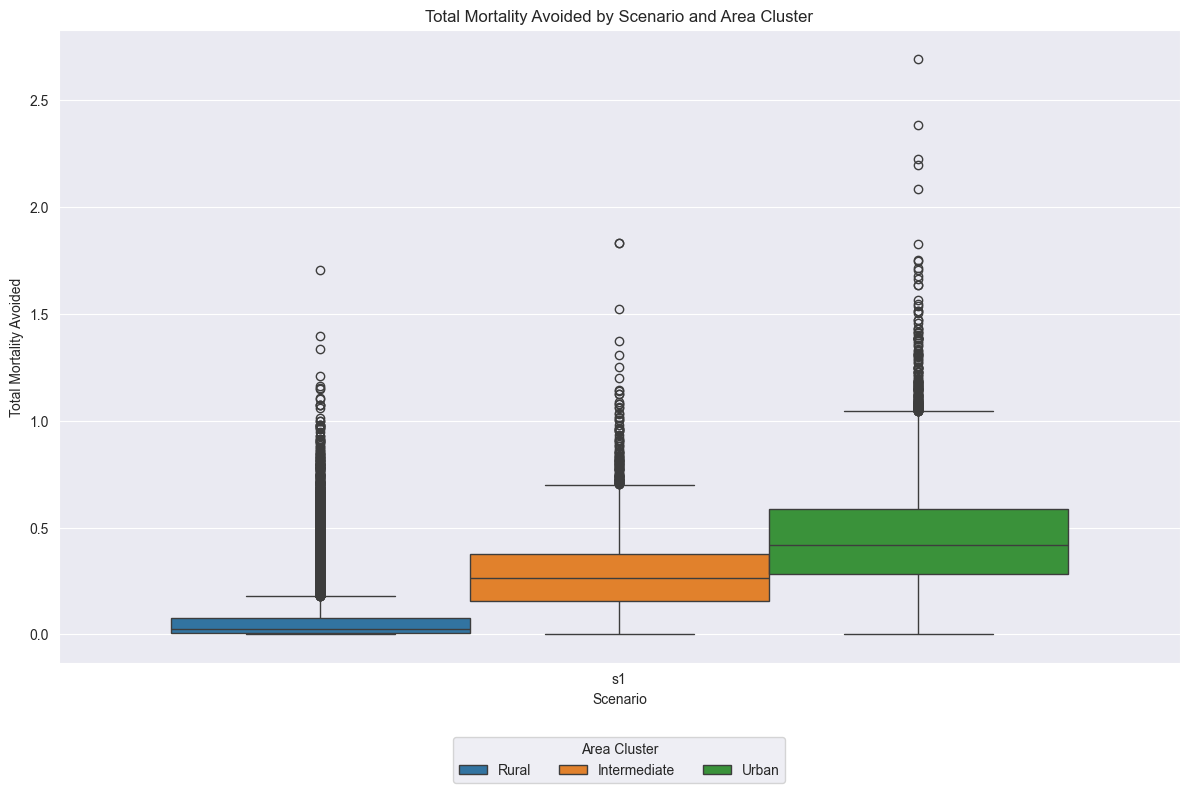

In [8]:
# Create a DataFrame from results
df = pd.DataFrame(all_data)
base_path = "data/2-output-data"

# Check and visualize data if not empty
if not df.empty:
    print("Debugging Data Distribution:")
    print(df.groupby(["Scenario", "Pollutant"])["total_mortality_avoided"].describe())

    # Generate and save boxplot by area_cluster
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x="Scenario", y="total_mortality_avoided", hue="Area_Cluster")
    plt.title("Total Mortality Avoided by Scenario and Area Cluster")
    plt.xlabel("Scenario")
    plt.ylabel("Total Mortality Avoided")
    plt.legend(title="Area Cluster", loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3)  # Adjusted legend position
    plt.tight_layout()
    output_path = os.path.join(base_path, "Boxplot_Total_Mortality_Avoided_by_Area_Cluster.png")
    plt.savefig(output_path, dpi=300)
    plt.show()
else:
    print("DataFrame is empty; no data to analyze or visualize.")

In [5]:
all_data = []
scenarios = ["s1"]  # Multiple scenarios now for testing
pollutants = ["ug_NO2"]  # ug_PM25_RH50
years = [2030]

# Iterate over scenarios, pollutants, and years
total_iterations = len(scenarios) * len(pollutants) * len(years)
current_iteration = 0

for scenario in scenarios:
    for pollutant in pollutants:
        for year in years:
            current_iteration += 1
            start_time = time.time()  # Time each loop iteration
            print(f"Processing {current_iteration}/{total_iterations} - Scenario: {scenario}, Pollutant: {pollutant}, Year: {year}")
            try:
                # Reload pollutant data specific to scenario
                conc_points = coordo_sherpa(scenario, pollutant, year)

                # Reload and correct concentration data for the current pollutant
                conc_ineris = coordo_ineris(pollutant)
                conc_corrigee = correction(conc_points, conc_ineris)

                # Calculate exposure data
                donnees_expo = expo(donnees_exportees_transformed, conc_corrigee, grille_combinee)

                # Debugging - Check exposure data for this scenario and pollutant
                print(f"Exposure data sample for scenario {scenario}, pollutant {pollutant}:")
                print(donnees_expo.head())

                # Compute mortality data
                mortality_data = calculate_iris_level_mortality_age_specific(
                    donnees_merged, donnees_expo, year, pollutant
                )
                print(mortality_data[["comcod", "total_mortality_avoided"]].head())

                # Check for key columns to merge
                if "comcod" in donnees_exportees_transformed.columns:
                    key_column = "comcod"
                else:
                    print("Inspecting available columns in donnees_exportees_transformed:")
                    print(donnees_exportees_transformed.columns)
                    raise KeyError("'comcod' column is missing in donnees_exportees_transformed.")

                if "comcod" not in mortality_data.columns:
                    print("Inspecting available columns in mortality_data:")
                    print(mortality_data.columns)
                    raise KeyError("'comcod' column is missing in mortality_data.")

                print(f"Using '{key_column}' as the key column for merging.")

                # Join clusters back to mortality dataset
                mortality_data_total = mortality_data.merge(
                    donnees_exportees_transformed[[key_column, "area_cluster", "pop2030", "geometry"]],
                    on=key_column,
                    how="left"
                )

                # Check and handle duplicate geometry columns in mortality_data_total
                duplicate_geometry_cols = ["geometry_x", "geometry_y"]
                if all(col in mortality_data_total.columns for col in duplicate_geometry_cols):
                    print(f"Duplicate geometry columns detected: {duplicate_geometry_cols}. Prioritizing 'geometry_x'.")
                    mortality_data_total["geometry"] = mortality_data_total["geometry_x"]
                    mortality_data_total.drop(columns=duplicate_geometry_cols, inplace=True)
                    mortality_data_total.set_geometry("geometry", inplace=True)

                # Debugging: Check mortality data for this scenario and pollutant
                print(f"Mortality data for scenario {scenario}, pollutant {pollutant}:")
                print(mortality_data_total.head())

                # Add data to all_data list
                for _, row in mortality_data_total.iterrows():
                    all_data.append({
                        "Year": year,
                        "Scenario": scenario,
                        "Pollutant": "PM2.5" if pollutant == "ug_PM25_RH50" else "NO2",
                        "total_mortality_avoided": row.get("total_mortality_avoided"),
                        "years_gained_age_specific": row.get("total_years_gained"),
                        "Area_Cluster": row.get("area_cluster", None),
                        "comcod": row.get("comcod"),
                        "geometry": row.get("geometry")  # Include geometry for mapping
                    })

                # Convert to GeoDataFrame for visualization
                if all_data:
                    gdf_all_data = gpd.GeoDataFrame(
                        all_data,
                        geometry=[row.get("geometry") for row in all_data],
                        crs=donnees_exportees_transformed.crs
                    )

                    # Ensure active geometry column
                    gdf_all_data.set_geometry("geometry", inplace=True)

                    # Use the plotting function to create a unified map
                    plot_unified_iris_map_by_clusters(
                        iris_level_results=gdf_all_data,
                        iris_shapefile=donnees_exportees_transformed,
                        columns_to_plot=["total_mortality_avoided", "years_gained_age_specific"],
                        titles=["Mortality Avoided", "Years Gained"],
                        cmap="tab10",
                        base_path="data/2-output-data"
                    )

            except KeyError as ke:
                print(f"KeyError: {ke}")
            except Exception as e:
                print(f"Error processing Scenario: {scenario}, Pollutant: {pollutant}, Year: {year} - {e}")
            finally:
                elapsed_time = time.time() - start_time  # Measure elapsed time
                print(f"Completed {current_iteration}/{total_iterations} in {elapsed_time:.2f} seconds.")

Processing 1/1 - Scenario: s1, Pollutant: ug_NO2, Year: 2030
Concentrations in 2019 and 2030 are calculated for the pollutant 'ug_no2' (s1).
Starting coordo_ineris function
Loading data from data/1-processed-data/SHERPA/conc-2019/Reanalysed_FRA_2019_NO2_avgannual_Ineris_v.Jan2024.nc
Finished processing coordo_ineris function
Bounds of conc_points: [-4.75       41.375       9.55000019 51.07500076]
Bounds of conc_ineris: [-5.14062  41.33602   9.562505 51.08602 ]


C:\Users\aysharma\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aysharma\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aysharma\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aysharma\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aysharma\an

Exposure data sample for scenario s1, pollutant ug_NO2:
     iriscod      pop2019      pop2030      pop2050   mort2019   mort2030  \
0  010010000   501.359071   557.488387   628.777150   6.615553   8.259900   
1  010020000   164.759849   183.205426   206.632799   2.174046   2.714422   
2  010040101  1201.588428  1336.111448  1506.966546  15.855247  19.796192   
3  010040102  2315.648186  2574.895013  2904.159417  30.555531  38.150348   
4  010040201  2660.614120  2958.481374  3336.796840  35.107439  43.833669   

    mort2050                          irisname comcod  \
0  11.756833           L'Abergement-Clémenciat  01001   
1   3.863606             L'Abergement-de-Varey  01002   
2  28.177161  Les Perouses-Triangle d'Activité  01004   
3  54.301780                     Longeray-Gare  01004   
4  62.391206    Centre-Saint-Germain-Vareilles  01004   

                   comname depcod depname regcod               regname  \
0  L'Abergement-Clémenciat     01     Ain     84  Auvergne-Rhône